# Summary plot

__last update__: 20/01/22

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import copy
import numpy as np
import pickle as pkl
from astropy.io import fits
from scipy.optimize import minimize
import seaborn as sns # for nicer colors on the plot
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, ListedColormap, TwoSlopeNorm
from matplotlib import patches as mpatches
%matplotlib inline
plt.rc('image', interpolation='none', origin='lower')

from herculens.Util.plot_util import nice_colorbar, nice_colorbar_residuals

In [2]:
SAVE_FIGURES = False
figure_dir = os.path.join('figures', 'full fits')

SAVE_PANELS_AS_FITS = False
figure_dir_panels = os.path.join('figures', 'full fits', 'separate panels')

In [3]:
# Define some custom colormaps
#try:
#    import palettable
#except ImportError:
#    cmap_base = plt.get_cmap('cubehelix')
#else:
#    cmap_base = palettable.cubehelix.Cubehelix.make(name='flux_colormap',
#                                                    start=0.5,
#                                                    rotation=-1,
#                                                    gamma=0.8,
#                                                    sat=0.8,
#                                                    n=256).mpl_colormap
cmap_base = copy.copy(plt.get_cmap('magma'))
cmap_base.set_under('black')
cmap_base.set_over('white')
cmap_flux = copy.copy(cmap_base)
cmap_flux.set_bad(color='black')
cmap_flux_alt = copy.copy(cmap_base)
cmap_flux_alt.set_bad(color='#222222')  # to emphasize non-positive pixels in log scale
cmap_res = plt.get_cmap('RdBu_r')
cmap_corr = copy.copy(plt.get_cmap('Spectral'))
cmap_corr_cut = ListedColormap(cmap_corr(np.linspace(0.5, 1, 128)))
cmap_default = plt.get_cmap('viridis')
cmap_deriv1 = plt.get_cmap('cividis')
cmap_deriv2 = plt.get_cmap('inferno')

In [4]:
# types of potential perturbations we consider
perturb_types = ['dark halo', 'discyness', 'GRF']

# for each case, load the saved data from the modeling
full_model_data, smooth_model_data, pixsrc_model_data = {}, {}, {}
for perturb_type in perturb_types:
    with open(os.path.join('results', f'sumplot-{perturb_type.replace(" ", "_")}-scale_4-smooth_source.pkl'), 'rb') as f:
        content = pkl.load(f)
        full_model_data[perturb_type] = content
    with open(os.path.join('results', f'sumplot-{perturb_type.replace(" ", "_")}-fully_smooth_fit-smooth_source.pkl'), 'rb') as f:
        content = pkl.load(f)
        smooth_model_data[perturb_type] = content
    with open(os.path.join('results', f'sumplot-{perturb_type.replace(" ", "_")}-fully_smooth_fit-wavelet_source.pkl'), 'rb') as f:
        content = pkl.load(f)
        pixsrc_model_data[perturb_type] = content

In [5]:
def optimal_offset(model, target, mask=None, noise_map=None):
    """Function to minimize constant offset between two images."""
    if mask is None: mask = np.ones_like(target)
    if noise_map is None: noise_map = np.ones_like(model)
    loss_fun = lambda offset: 0.5 * np.sum(mask*(model+offset - target)**2/noise_map**2)
    init_offset = 0.
    result = minimize(loss_fun, init_offset)
    final_offset = float(result.x[0])
    return final_offset 

def levels_for_source(image, frac_levels=[0.5], n=1000):
    """compute specific levels from an image, based on fraction of the total flux.
    Useful for getting an (approximated) half-light radius from an image.
    Note that 'total light' here is defined as the sum of the `image` pixels.
    """
    from scipy import interpolate
    z = np.array(image)
    t = np.linspace(0.0, z.max(), n)
    integral = ((z >= t[:, None, None]) * z).sum(axis=(1, 2))
    f = interpolate.interp1d(integral, t)
    levels = f(np.array(frac_levels) * z.sum())
    return levels

In [6]:
def set_column_title(ax, title, fontsize=16):
    ax.text(0.5, 1.05, title, transform=ax.transAxes, 
            ha='center', va='bottom', fontsize=fontsize)
def set_row_title(ax, title, fontsize=16):
    ax.text(0, 0.5, title, transform=ax.transAxes, 
            ha='left', va='center', fontsize=fontsize)
    
def add_scale_bar(ax, extent, pixel_size, size_arcsec=1, bar_width_pixel=1, 
                  position=None, color='white', fontsize=16):
    if position is None:
        position = (extent[0]+5*pixel_size, extent[2]+5*pixel_size)
    width, height = size_arcsec, bar_width_pixel*pixel_size
    bar = mpatches.Rectangle(position, width, height, facecolor=color)
    ax.add_patch(bar)
    text_offset_y = 2 * height
    text = '{}"'.format(size_arcsec)
    ax.text(position[0]+width/2., position[1]+text_offset_y, text, color=color, fontsize=fontsize, 
            horizontalalignment='center', verticalalignment='bottom')

def add_title_box(ax, text, fontsize=16, txt_color='white', bg_color='black'):
    ax.text(0.05, 0.95, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.5})
    
def add_text_box(ax, text, loc='right', fontsize=16, txt_color='black', bg_color='white'):
    if loc == 'right':
        x, y = 0.95, 0.05
        ha, va = 'right', 'bottom'
    elif loc == 'left':
        x, y = 0.05, 0.05
        ha, va = 'left', 'bottom'
    ax.text(x, y, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment=ha, verticalalignment=va,
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.7})
    
def add_imshow_inset(ax, image, edge_color='white', **kwargs_imshow):
    w, h = 0.35, 0.35 # relative to ax size
    ax_ins = ax.inset_axes([-0.05, 1.05-h, w, h])
    ax_ins.set_xticks([]); ax_ins.set_yticks([])
    im_ins = ax_ins.imshow(image, **kwargs_imshow)
    im_ins.set_rasterized(True)
    ax_ins.spines['bottom'].set_color(edge_color)
    ax_ins.spines['top'].set_color(edge_color)
    ax_ins.spines['left'].set_color(edge_color)
    ax_ins.spines['right'].set_color(edge_color)
    return ax_ins

potential model offset = 0.035
potential model offset = 0.002
potential model offset = 0.031


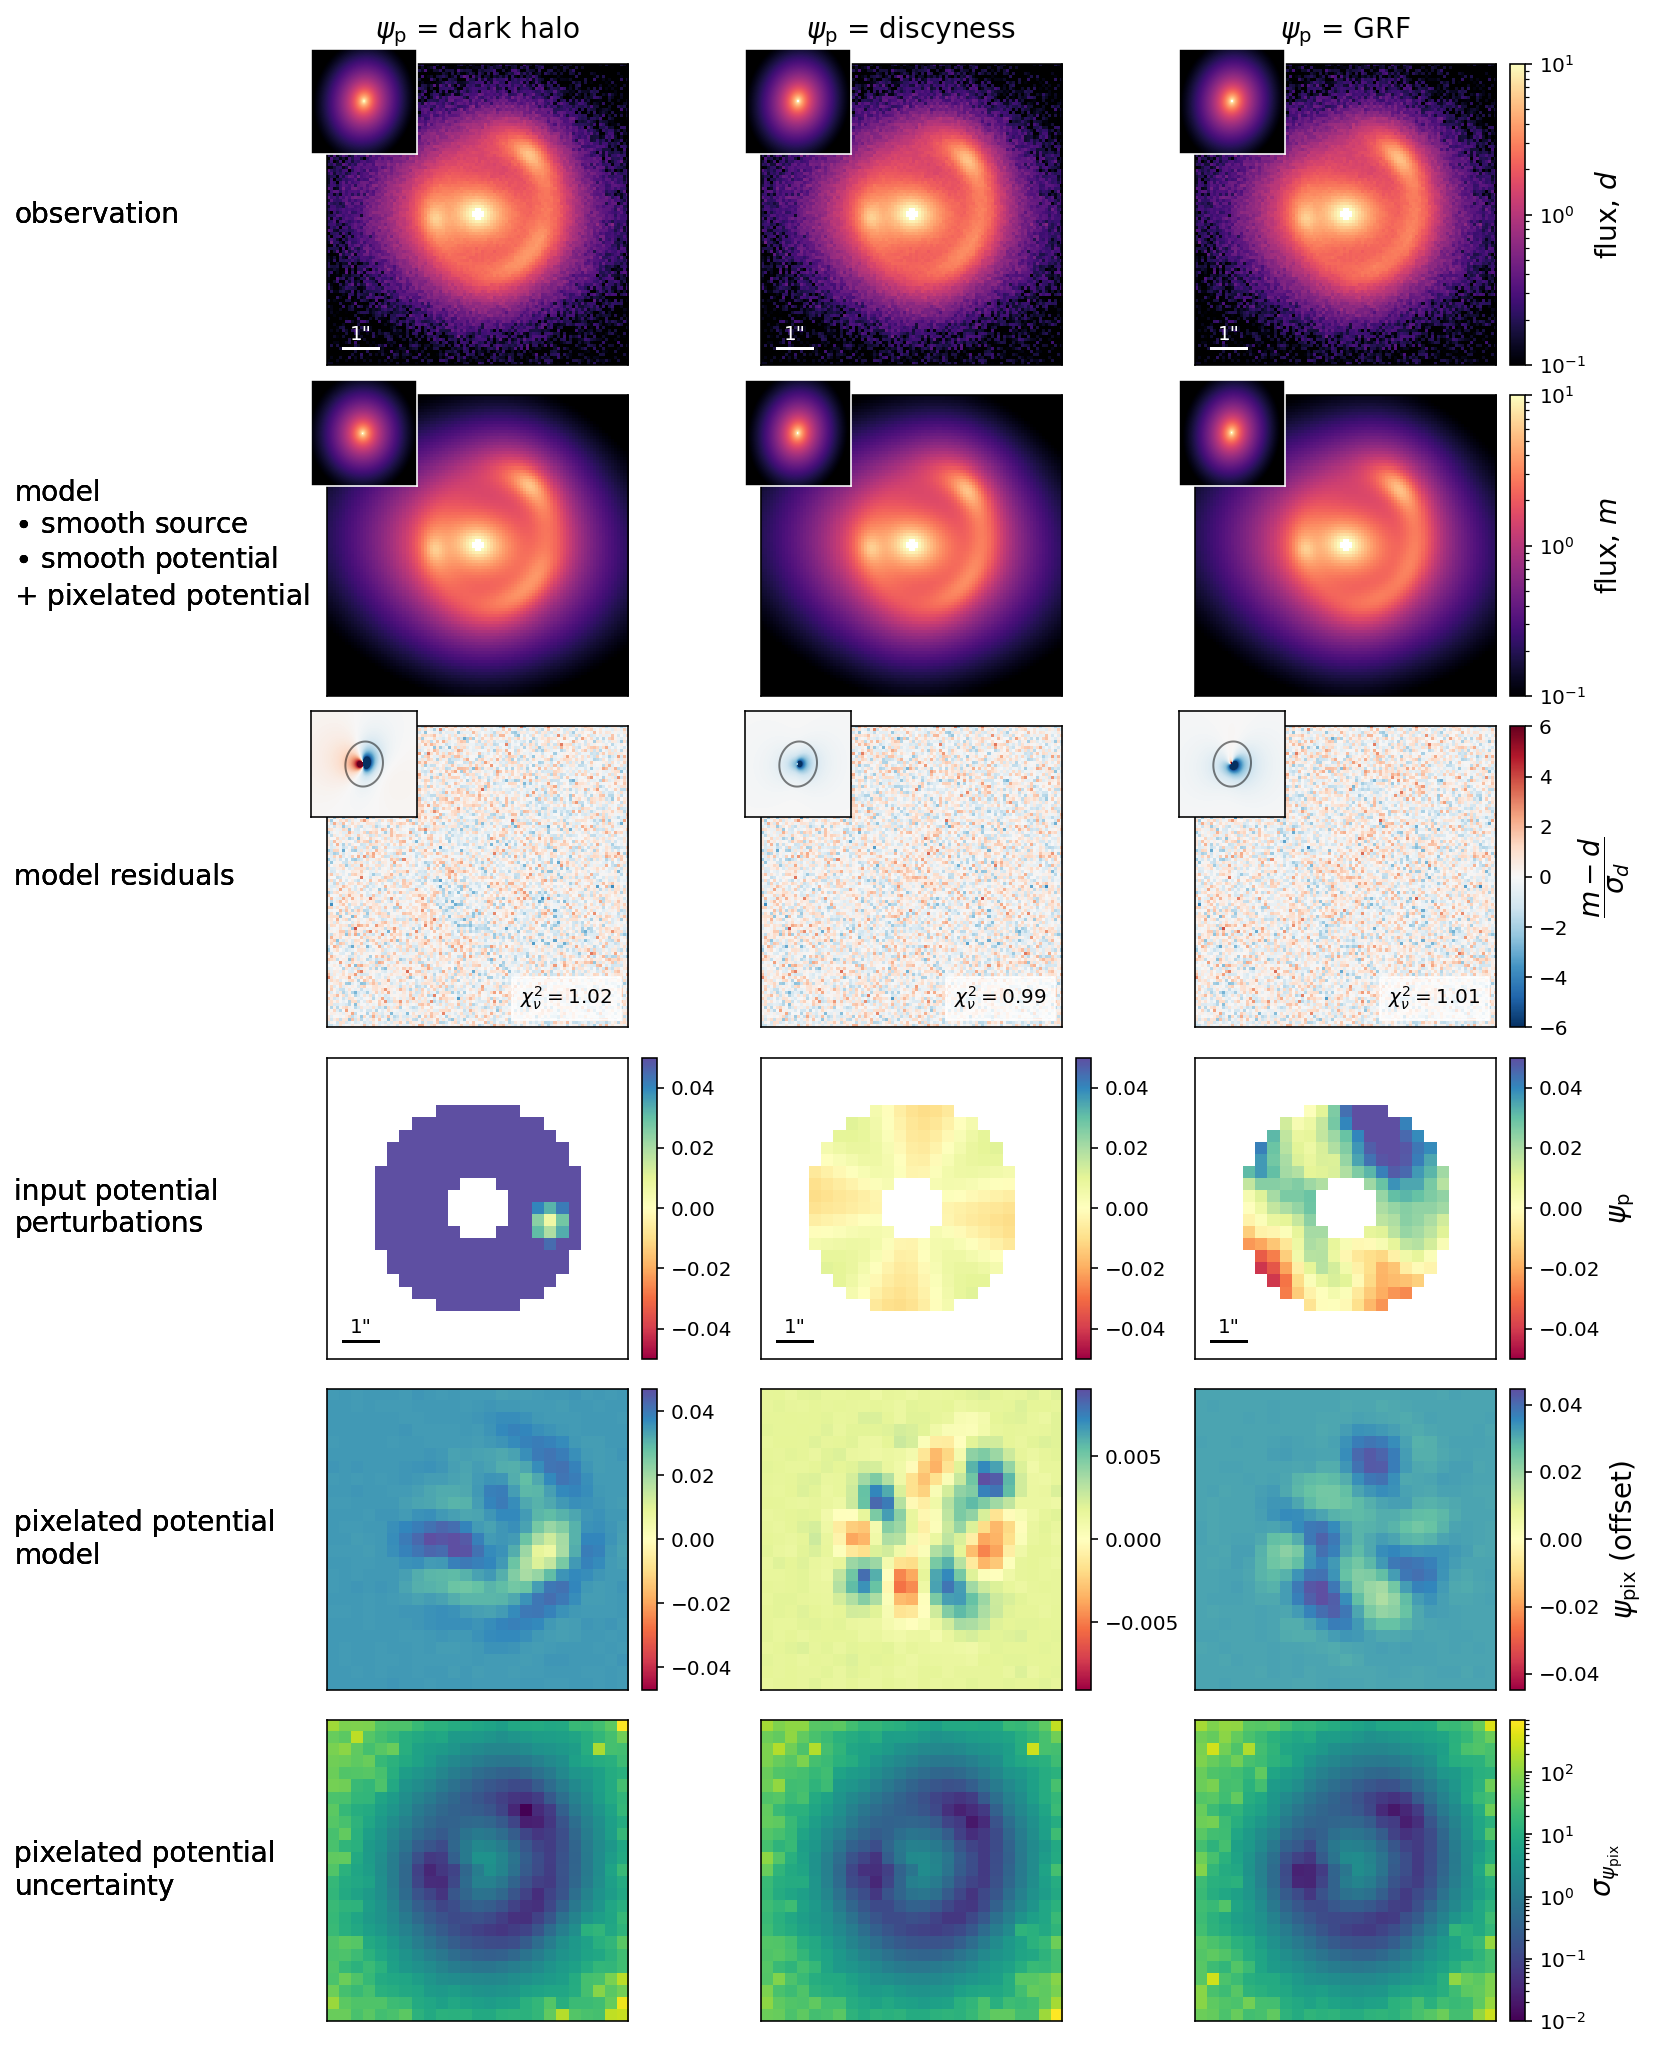

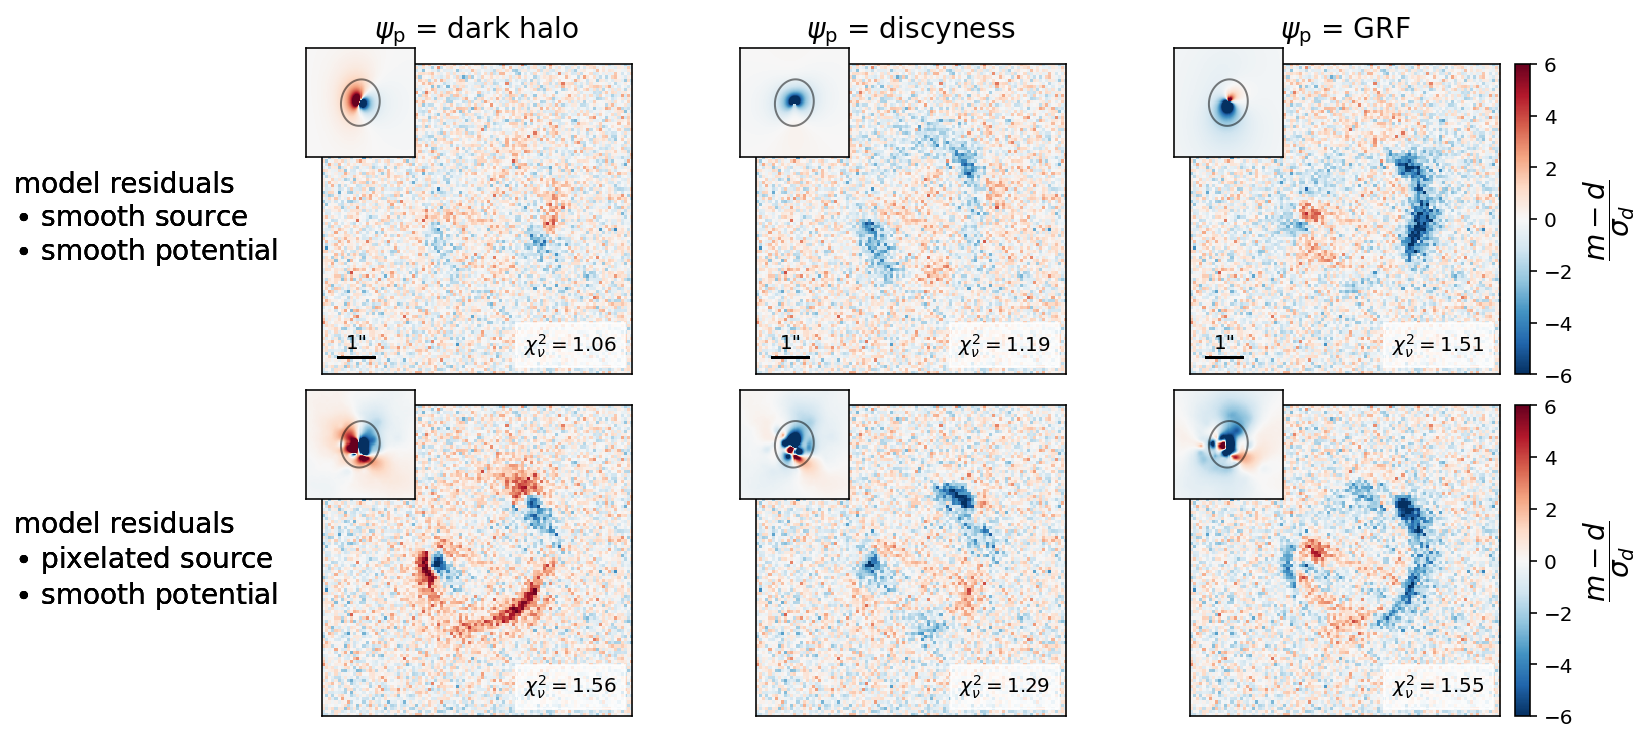

In [10]:
fontsize = 14
source_zoom_in = True
shared_pixpot_norms = False

norm_flux = LogNorm(1e-1, 1e1)
norm_res = Normalize(-6, 6)
norm_diff_src = Normalize(-0.5, 0.5)
norm_pot = Normalize(-0.05, 0.05)
norm_res_pot = Normalize(-1, 1)
norm_pot_err = LogNorm()

cb_pad = 0.1
num_rows = 6
num_cols =  len(perturb_types)
fig, axes = plt.subplots(num_rows, 1+num_cols,
                         gridspec_kw={'width_ratios':[0.6]+[1]*num_cols},
                         figsize=(14, 18))

num_rows2 = 2
num_cols2 =  len(perturb_types)
fig2, axes2 = plt.subplots(num_rows2, 1+num_cols2,
                           gridspec_kw={'width_ratios':[0.6]+[1]*num_cols2},
                           figsize=(14, 6))
        
# deactivate all axis on first column
for k in range(num_rows):
    axes[k, 0].axis('off')
for k in range(num_rows2):
    axes2[k, 0].axis('off')
# remove all ticks from axes
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
for ax in axes2.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    
for i, perturb_type in enumerate(perturb_types):
    
    ###################
    
    # load all necessary data
    data, full_lens_image, full_kwargs_result, input_kwargs_result, \
        _, potential_noise_map, \
        perturb_input, perturb_input_fitgrid, \
        hessian_model \
        = full_model_data[perturb_type]
    _, smooth_lens_image, smooth_kwargs_result, = smooth_model_data[perturb_type]
    _, pixsrc_lens_image, pixsrc_kwargs_result, = pixsrc_model_data[perturb_type]
    
    extent = full_lens_image.Grid.extent
    pixel_size = full_lens_image.Grid.pixel_width
    x_grid, y_grid = full_lens_image.Grid.pixel_coordinates
    x_grid_fit, y_grid_fit = full_lens_image.Grid.model_pixel_coordinates('lens')
    
    full_model = full_lens_image.model(**full_kwargs_result)
    
    smooth_model = smooth_lens_image.model(**smooth_kwargs_result)
    smooth_noise_map = np.sqrt(smooth_lens_image.Noise.C_D_model(smooth_model))
    smooth_res = (smooth_model - data) / smooth_noise_map
    smooth_red_chi2 = np.sum(smooth_res**2) / smooth_res.size
    
    pixsrc_model = pixsrc_lens_image.model(**pixsrc_kwargs_result)
    pixsrc_noise_map = np.sqrt(pixsrc_lens_image.Noise.C_D_model(pixsrc_model))
    pixsrc_res = (pixsrc_model - data) / pixsrc_noise_map
    pixsrc_red_chi2 = np.sum(pixsrc_res**2) / pixsrc_res.size
    
    full_model = full_lens_image.model(**full_kwargs_result)
    full_noise_map = np.sqrt(full_lens_image.Noise.C_D_model(full_model))
    full_res = (full_model - data) / full_noise_map
    full_red_chi2 = np.sum(full_res**2) / full_res.size
    
    perturb_model = full_kwargs_result['kwargs_lens'][-1]['pixels']
    num_lens, num_src = 5, 7
    perturb_error = np.sqrt(1. / np.abs(np.diag(hessian_model[num_lens:-num_src, num_lens:-num_src])))
    perturb_error = perturb_error.reshape(*perturb_model.shape)
    
    source_model = full_lens_image.source_surface_brightness(full_kwargs_result['kwargs_source'], 
                                                              kwargs_lens=full_kwargs_result['kwargs_lens'])
    
    # generate masks for potential perturbations
    rmin, rmax = 0.8, 2.8
    radius_fit = np.hypot(x_grid_fit, y_grid_fit)
    pot_mask_fitgrid = ((radius_fit >= rmin) & (radius_fit <= rmax)).astype(float)
    radius = np.hypot(x_grid, y_grid)
    pot_mask = ((radius >= rmin) & (radius <= rmax)).astype(float)

    if source_zoom_in:
        # create a grid for zooming in on source model panels
        src_center = (input_kwargs_result['kwargs_source'][0]['center_x'], 
                      input_kwargs_result['kwargs_source'][0]['center_y'])
        full_lens_image.Grid.create_model_grid(grid_center=src_center,
                                               grid_shape=(2.8, 2.8),
                                               pixel_scale_factor=0.33,
                                               name='source_plot', overwrite=True)
        extent_src =  full_lens_image.Grid.model_pixel_extent('source_plot')
        pixel_size_src =  full_lens_image.Grid.model_pixel_width('source_plot')
        x_grid_src, y_grid_src = full_lens_image.Grid.model_pixel_coordinates('source_plot')
    else:
        extent_src = extent
        pixel_size_src = pixel_size
        x_grid_src, y_grid_src = x_grid, y_grid
    src_model = full_lens_image.SourceModel.surface_brightness(
        x_grid_src, y_grid_src, full_kwargs_result['kwargs_source']) \
        * full_lens_image.Grid.pixel_area
    src_smo_model = smooth_lens_image.SourceModel.surface_brightness(
        x_grid_src, y_grid_src, smooth_kwargs_result['kwargs_source']) \
        * full_lens_image.Grid.pixel_area
    src_pix_model = pixsrc_lens_image.SourceModel.surface_brightness(
        x_grid_src, y_grid_src, pixsrc_kwargs_result['kwargs_source']) \
        * full_lens_image.Grid.pixel_area
    src_input = full_lens_image.SourceModel.surface_brightness(
        x_grid_src, y_grid_src, input_kwargs_result['kwargs_source']) \
        * full_lens_image.Grid.pixel_area
    #src_input_total_flux = full_lens_image.SourceModel.func_list[0].total_flux(
    #    **input_kwargs_result['kwargs_source'][0]) #* full_lens_image.Grid.pixel_area
    src_levels = levels_for_source(src_input, frac_levels=[0.5])
    
    # relative differences
    src_diff = (src_model - src_input) / src_input
    src_smo_diff = (src_smo_model - src_input) / src_input
    src_pix_diff = (src_pix_model - src_input) / src_input
    
    # normalized residuals
    approx_src_noise_map = full_noise_map[pot_mask == 1].mean()
    src_res = (src_model - src_input) / approx_src_noise_map
    src_smo_res = (src_smo_model - src_input) / approx_src_noise_map
    src_pix_res = (src_pix_model - src_input) / approx_src_noise_map
    
    ###################
        
    # misc
    last_col = (i == num_cols-1)
    
    # 1) imaging data
    ax = axes[0, i+1]
    set_column_title(ax, r"$\psi_{\rm p}$"+f" = {perturb_type}", fontsize=fontsize)
    set_row_title(axes[0, 0], "observation", fontsize=fontsize)
    im = ax.imshow(data, extent=extent, norm=norm_flux, cmap=cmap_flux)
    im.set_rasterized(True)
    nice_colorbar(im, pad=cb_pad,  label=r"flux, $d$", 
                  fontsize=fontsize, invisible=not last_col)
    add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                  color='white', fontsize=fontsize-4)
    add_imshow_inset(ax, src_input, extent=extent_src, norm=norm_flux, cmap=cmap_flux)
    
    # 2) full model
    ax = axes[1, i+1]
    set_row_title(axes[1, 0], "model\n"+r"$\bullet$"+" smooth source\n"+r"$\bullet$"+" smooth potential\n"+r"$+$"+" pixelated potential", fontsize=fontsize)
    im = ax.imshow(full_model, extent=extent, norm=norm_flux, cmap=cmap_flux)
    im.set_rasterized(True)
    nice_colorbar(im, pad=cb_pad, label=r"flux, $m$", fontsize=fontsize, invisible=not last_col)
    add_imshow_inset(ax, src_model, extent=extent_src, norm=norm_flux, cmap=cmap_flux)

    # 3) image residuals for smooth model with smooth source
    ax = axes2[0, i+1]
    set_column_title(ax, r"$\psi_{\rm p}$"+f" = {perturb_type}", fontsize=fontsize)
    set_row_title(axes2[0, 0], "model residuals\n"+r"$\bullet$"+" smooth source\n"+r"$\bullet$"+" smooth potential", 
                  fontsize=fontsize)
    im = ax.imshow(smooth_res, extent=extent, norm=norm_res, cmap=cmap_res)
    im.set_rasterized(True)
    nice_colorbar(im, pad=cb_pad, fontsize=fontsize,
                  label=r"$\dfrac{m - d}{\sigma_d}$", 
                  invisible=not last_col)
    add_text_box(ax, r"$\chi^2_\nu=$"+f"{smooth_red_chi2:.2f}", 
                 fontsize=fontsize-4, txt_color='black', bg_color='white')
    add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                  color='black', fontsize=fontsize-4)
    #ax_ins = add_imshow_inset(ax, src_smo_diff, edge_color='black', extent=extent_src, norm=norm_diff_src, cmap=cmap_res)
    ax_ins = add_imshow_inset(ax, src_smo_res, edge_color='black', extent=extent_src, norm=norm_res, cmap=cmap_res)
    ax_ins.contour(src_input, extent=extent_src, levels=src_levels, colors='black', linewidths=1, alpha=0.5)
    
    # 4) image residuals for smooth model with pixelated source
    ax = axes2[1, i+1]
    set_row_title(axes2[1, 0], "model residuals\n"+r"$\bullet$"+" pixelated source\n"+r"$\bullet$"+" smooth potential", 
                  fontsize=fontsize)
    im = ax.imshow(pixsrc_res, extent=extent, norm=norm_res, cmap=cmap_res)
    im.set_rasterized(True)
    nice_colorbar(im, pad=cb_pad, fontsize=fontsize,
                  label=r"$\dfrac{m - d}{\sigma_d}$", 
                  invisible=not last_col)
    add_text_box(ax, r"$\chi^2_\nu=$"+f"{pixsrc_red_chi2:.2f}", 
                 fontsize=fontsize-4, txt_color='black', bg_color='white')
    #ax_ins = add_imshow_inset(ax, src_pix_diff, edge_color='black', extent=extent_src, norm=norm_diff_src, cmap=cmap_res)
    ax_ins = add_imshow_inset(ax, src_pix_res, edge_color='black', extent=extent_src, norm=norm_res, cmap=cmap_res)
    ax_ins.contour(src_input, extent=extent_src, levels=src_levels, colors='black', linewidths=1, alpha=0.5)
    
    # 5) image residuals for full model
    ax = axes[2, i+1]
    set_row_title(axes[2, 0], "model residuals",
                  fontsize=fontsize)
    im = ax.imshow(full_res, extent=extent, norm=norm_res, cmap=cmap_res)
    im.set_rasterized(True)
    nice_colorbar(im, pad=cb_pad, fontsize=fontsize,
                  label=r"$\dfrac{m - d}{\sigma_d}$", 
                  invisible=not last_col)
    add_text_box(ax, r"$\chi^2_\nu=$"+f"{full_red_chi2:.2f}", 
                 fontsize=fontsize-4, txt_color='black', bg_color='white')
    #ax_ins = add_imshow_inset(ax, src_diff, edge_color='black', extent=extent_src, norm=norm_diff_src, cmap=cmap_res)
    ax_ins = add_imshow_inset(ax, src_res, edge_color='black', extent=extent_src, norm=norm_res, cmap=cmap_res)
    ax_ins.contour(src_input, extent=extent_src, levels=src_levels, colors='black', linewidths=1, alpha=0.5)
    
    # 6) input potential perturbations
    if perturb_type == 'dark halo':
        cmap_pot = cmap_corr
    else:
        cmap_pot = cmap_corr
    ax = axes[3, i+1]
    set_row_title(axes[3, 0], "input potential\nperturbations", fontsize=fontsize)
    perturb_input_fitgrid_plt = perturb_input_fitgrid.copy()
    perturb_input_fitgrid_plt[pot_mask_fitgrid==0] = np.nan
    im = ax.imshow(perturb_input_fitgrid_plt, 
                   extent=extent, cmap=cmap_pot, norm=norm_pot)
    im.set_rasterized(True)
    label = r"$\psi_{\rm p}$" if last_col else None
    nice_colorbar(im, pad=cb_pad, label=label, fontsize=fontsize)
    add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                  color='black', fontsize=fontsize-4)
    
    # 7) reconstructed potential perturbations
    if perturb_type == 'dark halo':
        offset_model = - perturb_model.min() + perturb_input_fitgrid.min()
    else:
        #offset_model = - perturb_model[pot_mask_fitgrid == 0].mean()
        #offset_model = -perturb_model[pot_mask_fitgrid == 0].min()
        offset_model = optimal_offset(perturb_model, 
                                      perturb_input_fitgrid, 
                                      mask=pot_mask_fitgrid,
                                      noise_map=perturb_error)
    #
    #else:
    #    norm_pot_model = None
    print(f"potential model offset = {offset_model:.3f}")
    perturb_model_o = perturb_model + offset_model
    vmax_pot = np.abs(perturb_model_o[pot_mask_fitgrid==1]).max()
    if perturb_type == 'dark halo':
        if shared_pixpot_norms:
            norm_pot_model = norm_pot
        else:
            norm_pot_model = Normalize(-vmax_pot, vmax_pot)
    else:
        if shared_pixpot_norms:
            norm_pot_model = norm_pot
        else:
            norm_pot_model = Normalize(-vmax_pot, vmax_pot)
    ax = axes[4, i+1]
    set_row_title(axes[4, 0], "pixelated potential\nmodel", fontsize=fontsize)
    im = ax.imshow(perturb_model_o, extent=extent, cmap=cmap_pot, norm=norm_pot_model)
    im.set_rasterized(True)
    label = r"$\psi_{\rm pix}$ (offset)" if last_col else None
    nice_colorbar(im, pad=cb_pad, label=label, fontsize=fontsize)

    
    # 8) perturbation standard deviation
    ax = axes[5, i+1]
    set_row_title(axes[5, 0], "pixelated potential\nuncertainty", fontsize=fontsize)
    im = ax.imshow(perturb_error, extent=extent, cmap=cmap_default, norm=norm_pot_err)
    im.set_rasterized(True)
    label = r"$\sigma_{\psi_{\rm pix}}$" if last_col else None
    nice_colorbar(im, pad=cb_pad, label=label, fontsize=fontsize, invisible=not last_col)
    
    if SAVE_PANELS_AS_FITS:
        panel_basename = f"wavelet_pot-smooth_src-full_fit-type_{perturb_type.replace(' ', '_')}-"
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'data' + '.fits'),
                     np.array(data), overwrite=True)
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'full_model' + '.fits'),
                     np.array(full_model), overwrite=True)
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'smooth_resid' + '.fits'),
                     np.array(smooth_res), overwrite=True)
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'full_resid' + '.fits'),
                     np.array(full_res), overwrite=True)
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'input_pert' + '.fits'),
                     np.array(perturb_input_fitgrid), overwrite=True)
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'model_pert' + '.fits'),
                     np.array(perturb_model), overwrite=True)
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'pot_mask' + '.fits'),
                     np.array(pot_mask_fitgrid), overwrite=True)
        
fig.subplots_adjust(hspace=0.1, wspace=0)
fig2.subplots_adjust(hspace=0.1, wspace=0)
plt.show()


In [8]:
if SAVE_FIGURES:
    # saving as pdf causes weird misalignments of axes, so I save in jpg
    figure_name = 'wavelet_pot-smooth_src-full_fit_summary.jpg'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight', dpi=200)
    
    figure2_name = 'wavelet_pot-smooth_src-full_fit_summary2.jpg'
    fig2.savefig(os.path.join(figure_dir, figure2_name), bbox_inches='tight', dpi=200)